# Introduction
In this notebook we will try to replicate results from the paper: 

# Pseudo Data Generation

In [65]:
import pandas as pd
import numpy as np

# Set seed for reproducibility
np.random.seed(42)

# Regimen allocation
regimen_counts = {
    "Split I": 407,
    "Split II": 415,
    "Control": 418
}

# Outcome distributions from the paper
# favourable_response_rates = {
#     "Split I": 0.912,
#     "Split II": 0.915,
#     "Control": 0.867
# }

# Balanced distribution
favourable_response_rates = {
    "Split I": 0.612,
    "Split II": 0.515,
    "Control": 0.467
}

# Gastro symptoms (higher in Control)
gastro_symptom_rates = {
    "Split I": 0.10,
    "Split II": 0.09,
    "Control": 0.17
}

# Drug resistance distribution
drug_resistance_options = ['None', 'H', 'R', 'H+R']
drug_resistance_probs = [0.85, 0.08, 0.05, 0.02]

# Helper function to generate patients for each group
def generate_patients(regimen, n):
    age = np.random.normal(32.5, 11.5, n).astype(int)
    weight = np.round(np.random.normal(40.5, 6.5, n), 1)
    sex = np.random.choice(['Male', 'Female'], size=n)
    smear_grade = np.random.choice(['0/1+', '2+/3+'], size=n, p=[0.45, 0.55])
    prev_treatment = np.random.choice(['<15 days', '>=15 days'], size=n, p=[0.8, 0.2])
    hiv_positive = [False] * n
    vision_defect = [False] * n
    favourable = np.random.rand(n) < favourable_response_rates[regimen]
    unfavourable = ~favourable
    relapse = favourable & (np.random.rand(n) < 0.04)
    quiescent = favourable & ~relapse
    gastro_symptoms = np.random.rand(n) < gastro_symptom_rates[regimen]
    drug_resistance = np.random.choice(drug_resistance_options, size=n, p=drug_resistance_probs)
    compliance = np.random.choice(['>75%', '<=75%'], size=n, p=[0.9, 0.1])
    follow_up = np.where(unfavourable, np.random.randint(1, 60, size=n), 60)

    return pd.DataFrame({
        "PatientID": [f"{regimen[:2]}-{i+1}" for i in range(n)],
        "Regimen": [regimen] * n,
        "Age": age,
        "Weight": weight,
        "Sex": sex,
        "SmearGrade": smear_grade,
        "PreviousTreatment": prev_treatment,
        "HIV_Positive": hiv_positive,
        "VisionDefect": vision_defect,
        "FavourableResponse": favourable,
        "UnfavourableResponse": unfavourable,
        "QuiescentAt5Yrs": quiescent,
        "Relapse": relapse,
        "GastroSymptoms": gastro_symptoms,
        "DrugResistance": drug_resistance,
        "Compliance": compliance,
        "FollowUpMonths": follow_up
    })

# Combine all patients
df_all = pd.concat([
    generate_patients(regimen, count)
    for regimen, count in regimen_counts.items()
], ignore_index=True)

# print(df_all.head())

# Save to CSV
csv_path = "data/synthetic_tb_clinical_trial_data.csv"
df_all.to_csv(csv_path, index=False)

# csv_path

# Load and Inspect the Dataset

In [66]:
import pandas as pd

df = pd.read_csv("data/synthetic_tb_clinical_trial_data.csv")
print(df.head())
print(df.info())

  PatientID  Regimen  Age  Weight     Sex SmearGrade PreviousTreatment  \
0      Sp-1  Split I   38    39.6    Male      2+/3+          <15 days   
1      Sp-2  Split I   30    41.3    Male       0/1+          <15 days   
2      Sp-3  Split I   39    43.8  Female      2+/3+          <15 days   
3      Sp-4  Split I   50    45.1    Male      2+/3+          <15 days   
4      Sp-5  Split I   29    33.2  Female       0/1+          <15 days   

   HIV_Positive  VisionDefect  FavourableResponse  UnfavourableResponse  \
0         False         False                True                 False   
1         False         False               False                  True   
2         False         False                True                 False   
3         False         False                True                 False   
4         False         False               False                  True   

   QuiescentAt5Yrs  Relapse  GastroSymptoms DrugResistance Compliance  \
0             True    False    

# Exploratory Data Analysis (EDA)

From your column names:

FavourableResponse and UnfavourableResponse are binary.

We want to define a single target variable (e.g. treatment_outcome) using these.

## Create a Unified treatment_outcome Column
We'll create a new column:

1 for FavourableResponse

0 for UnfavourableResponse

Drop rows where both are 0 or both are 1 (ambiguous cases)

In [67]:
import pandas as pd

df = pd.read_csv("data/synthetic_tb_clinical_trial_data.csv")

# print(df.head())

# Define treatment_outcome
df = df.copy()
# df['treatment_outcome'] = df['FavourableResponse'].where(df['FavourableResponse'] == 1, 0)
df['treatment_outcome'] = df['FavourableResponse'].astype(int)


# Remove rows where both are 0 or both are 1
df = df[(df['FavourableResponse'] != df['UnfavourableResponse'])]

df.drop(['FavourableResponse', 'UnfavourableResponse'], axis=1, inplace=True)

print(df['treatment_outcome'].value_counts())


treatment_outcome
1    635
0    605
Name: count, dtype: int64


In [68]:
df.keys()

Index(['PatientID', 'Regimen', 'Age', 'Weight', 'Sex', 'SmearGrade',
       'PreviousTreatment', 'HIV_Positive', 'VisionDefect', 'QuiescentAt5Yrs',
       'Relapse', 'GastroSymptoms', 'DrugResistance', 'Compliance',
       'FollowUpMonths', 'treatment_outcome'],
      dtype='object')

## Distribution of the Outcome

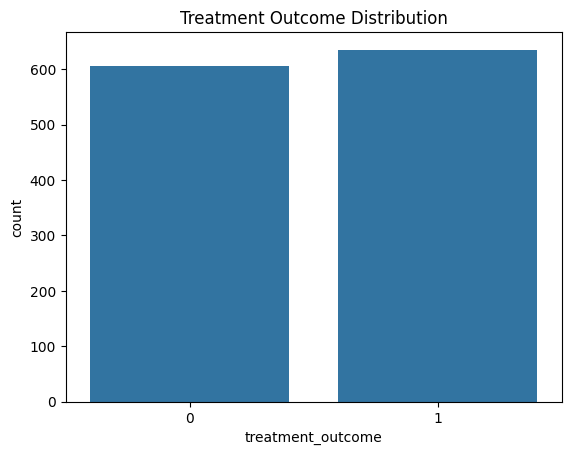

In [69]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.countplot(x='treatment_outcome', data=df)
plt.title('Treatment Outcome Distribution')
plt.show()

## Demographics (e.g., age, sex)

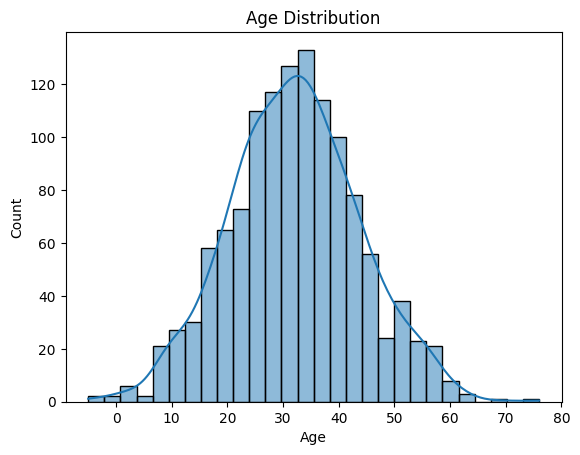

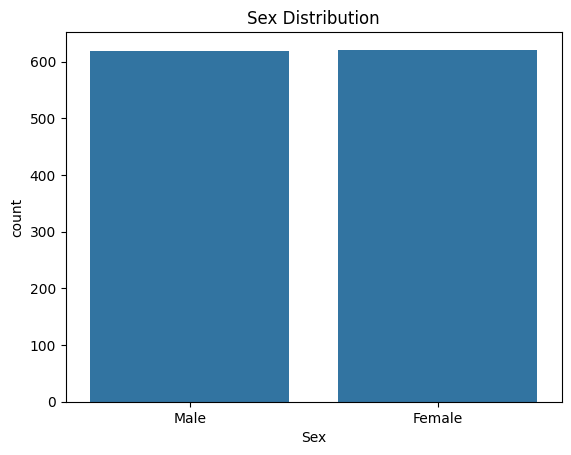

In [70]:
sns.histplot(df['Age'], kde=True)
plt.title('Age Distribution')
plt.show()

sns.countplot(x='Sex', data=df)
plt.title('Sex Distribution')
plt.show()

## Comorbidity and Symptoms

In [71]:
df_all.keys()

Index(['PatientID', 'Regimen', 'Age', 'Weight', 'Sex', 'SmearGrade',
       'PreviousTreatment', 'HIV_Positive', 'VisionDefect',
       'FavourableResponse', 'UnfavourableResponse', 'QuiescentAt5Yrs',
       'Relapse', 'GastroSymptoms', 'DrugResistance', 'Compliance',
       'FollowUpMonths'],
      dtype='object')

In [43]:
# comorbidity_columns = ['diabetes', 'hiv_status', 'smoking', 'alcohol_use']
# for col in comorbidity_columns:
#     sns.countplot(x=col, data=df)
#     plt.title(f'{col} Distribution')
#     plt.show()

## Correlation Heatmap

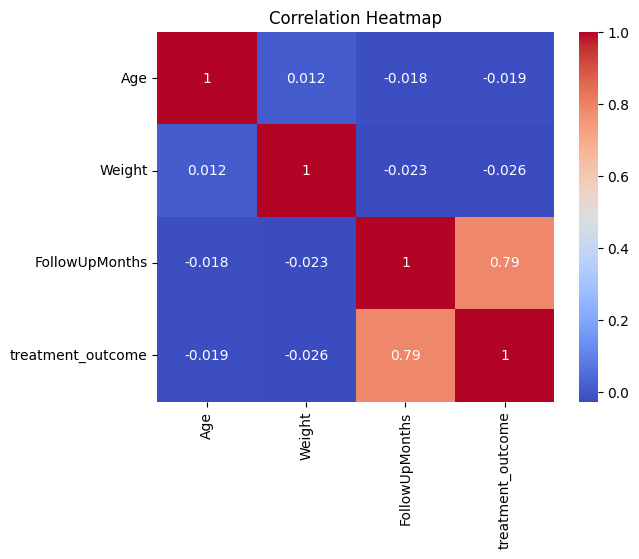

In [72]:
import numpy as np

numeric_df = df.select_dtypes(include=np.number)
correlation = numeric_df.corr()
sns.heatmap(correlation, annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

# Data Preprocessing

## Encode Categorical Variables

In [73]:
df_encoded = pd.get_dummies(df, drop_first=True)
df_encoded.keys()

Index(['Age', 'Weight', 'HIV_Positive', 'VisionDefect', 'QuiescentAt5Yrs',
       'Relapse', 'GastroSymptoms', 'FollowUpMonths', 'treatment_outcome',
       'PatientID_Co-10',
       ...
       'PatientID_Sp-98', 'PatientID_Sp-99', 'Regimen_Split I',
       'Regimen_Split II', 'Sex_Male', 'SmearGrade_2+/3+',
       'PreviousTreatment_>=15 days', 'DrugResistance_H+R', 'DrugResistance_R',
       'Compliance_>75%'],
      dtype='object', length=849)

## Train-Test Split

In [74]:
from sklearn.model_selection import train_test_split

X = df_encoded.drop('treatment_outcome', axis=1)  # Assume success=1, failure=0
y = df_encoded['treatment_outcome']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Train Machine Learning Models

We will try three models:

Logistic Regression

Random Forest

XGBoost

## Logistic Regression

In [75]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

lr = LogisticRegression(max_iter=1000)
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)

print("Logistic Regression Results:\n", classification_report(y_test, y_pred_lr))

Logistic Regression Results:
               precision    recall  f1-score   support

           0       1.00      0.99      1.00       121
           1       0.99      1.00      1.00       127

    accuracy                           1.00       248
   macro avg       1.00      1.00      1.00       248
weighted avg       1.00      1.00      1.00       248



## Random Forest

In [76]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

print("Random Forest Results:\n", classification_report(y_test, y_pred_rf))

Random Forest Results:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       121
           1       1.00      1.00      1.00       127

    accuracy                           1.00       248
   macro avg       1.00      1.00      1.00       248
weighted avg       1.00      1.00      1.00       248



## XGBoost

In [77]:
import xgboost as xgb

xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')
xgb_model.fit(X_train, y_train)
y_pred_xgb = xgb_model.predict(X_test)

print("XGBoost Results:\n", classification_report(y_test, y_pred_xgb))

c:\Users\Admin\miniconda3\envs\astromet\Lib\site-packages\xgboost\training.py:183: UserWarning: [16:42:42] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBoost Results:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       121
           1       1.00      1.00      1.00       127

    accuracy                           1.00       248
   macro avg       1.00      1.00      1.00       248
weighted avg       1.00      1.00      1.00       248



# Model Evaluation

## ROC Curve and AUC

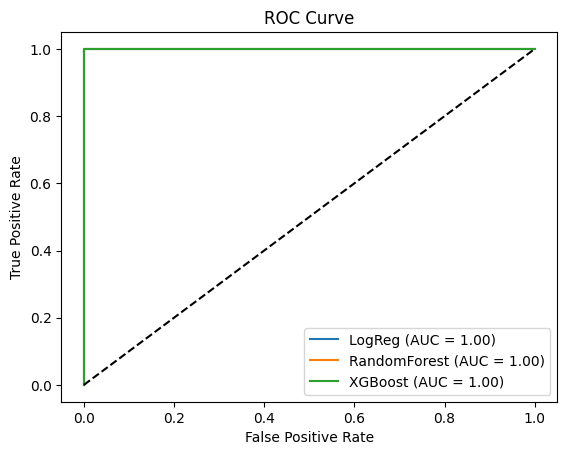

In [78]:
from sklearn.metrics import roc_auc_score, roc_curve

models = {'LogReg': lr, 'RandomForest': rf, 'XGBoost': xgb_model}

for name, model in models.items():
    y_probs = model.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_probs)
    auc = roc_auc_score(y_test, y_probs)
    plt.plot(fpr, tpr, label=f"{name} (AUC = {auc:.2f})")

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

## Feature Importance (Random Forest)

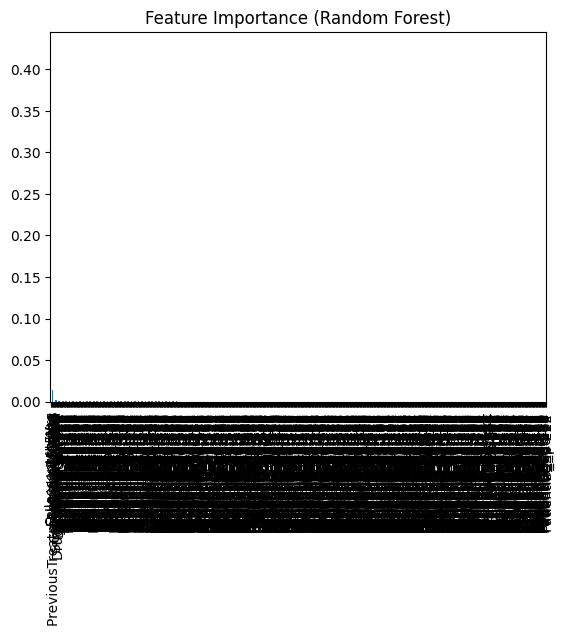

In [79]:
importances = rf.feature_importances_
features = X.columns
feat_imp = pd.Series(importances, index=features).sort_values(ascending=False)
feat_imp.plot(kind='bar', title='Feature Importance (Random Forest)')
plt.show()

# Conclusions